# Create json file of time-of-day PTC counts for Fig 4 lineChart

See https://github.com/CityofToronto/bdit_vfh/blob/master/notebooks/vfh_final.ipynb  

ref: https://geoffboeing.com/2015/10/exporting-python-data-geojson/  
Huom: `with open(output_filename, 'wb') as output_file:` should be `'w'` not `'wb'`  

**Resources**  
geoJSON minifier: https://jsonformatter.org/json-minify  

https://github.com/CityofToronto/bdit_vfh/blob/master/notebooks/vfh_final.ipynb  
**Trips by Time of Day and Day of Week, September 2018**  
**Exhibit 3-7**    

Query:

```
WITH sum AS (

SELECT pickup_datetime, hr, sum(count) as count, extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr,
extract(dow from pickup_datetime) as dow FROM ptc.trip_data_agg_ward_25


WHERE pickup_datetime > '2018-08-31'
GROUP BY pickup_datetime, hr

)
, collect AS (
SELECT  avg(count) as count, hr, dow from sum
group by hr, dow)

SELECT period_name, period_uid, count, hr, CASE WHEN dow = 0 THEN 7 ELSE dow END AS dow, 
CASE WHEN swatch IS NULL THEN '#999999' ELSE swatch END AS swatch
FROM collect
LEFT JOIN ptc.period_lookup_simple ON dow=period_dow AND hr=period_hr
LEFT JOIN ptc.periods_simple USING (period_uid)
ORDER BY dow, hr
```

**export file as:**   

In [35]:
import sys
sys.executable

'/home/test/anaconda3/envs/vfh/bin/python'

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

from IPython.display import HTML, display
import datetime
import matplotlib.dates as mdates
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

from datetime import datetime

import json

# Functions

In [37]:
# https://geoffboeing.com/2015/10/exporting-python-data-geojson/
def df_to_geojson(df, properties, lat="latitude", lon="longitude"):
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"Point",
                               "coordinates":[]}}
        feature["geometry"]["coordinates"] = [row[lon],row[lat]]
        for prop in properties:
            feature["properties"][prop] = int(row[prop])
        geojson["features"].append(feature)
    return geojson

# Variables

# Read PUDO data from csv file
Created by the following query:  
```
CREATE TABLE cnangini.trip_data_092018_counts AS
SELECT 
	TO_CHAR(pickup_datetime, 'FMDay') pickup_dow,
	TO_CHAR(pickup_datetime, 'HH24') pickup_hr,
	TO_CHAR(dropoff_datetime, 'FMDay') dropoff_dow,
	TO_CHAR(dropoff_datetime, 'HH24') dropoff_hr,
	pickup_ward2018, dropoff_ward2018, 
	pickup_neighbourhood, dropoff_neighbourhood
FROM ptc.trip_data_new_geom a
WHERE pickup_mun_id = 69 AND dropoff_mun_id = 69
AND pickup_datetime > '20180901' AND pickup_datetime < '20181001'
```

In [51]:
fname = '../../../Documents/PROJECTS/VFH/COT_PAGE/INTERIM_DATA/FROM_PGADMIN/tripdata_092018_forCounts.csv'

df = pd.read_csv(fname)

print(df.shape)
df.head(5)

(4164492, 8)


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood
0,Saturday,11,Saturday,11,12.0,10.0,104.0,76.0
1,Saturday,12,Saturday,12,10.0,13.0,78.0,75.0
2,Saturday,22,Saturday,22,10.0,11.0,76.0,76.0
3,Sunday,15,Sunday,15,13.0,11.0,77.0,76.0
4,Saturday,1,Saturday,1,11.0,5.0,95.0,111.0


In [52]:
hours = df['pickup_hr'].sort_values().unique()
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [53]:
print(df.loc[(df['pickup_dow']=='Monday') & 
            (df['pickup_hr']==0) &
            (df['pickup_ward2018']==10),'pickup_hr'].count())
df.loc[(df['pickup_dow']=='Monday') & (df['pickup_hr']==0) & (df['pickup_ward2018']==10)]

df.head(11)

4146


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood
0,Saturday,11,Saturday,11,12.0,10.0,104.0,76.0
1,Saturday,12,Saturday,12,10.0,13.0,78.0,75.0
2,Saturday,22,Saturday,22,10.0,11.0,76.0,76.0
3,Sunday,15,Sunday,15,13.0,11.0,77.0,76.0
4,Saturday,1,Saturday,1,11.0,5.0,95.0,111.0
5,Saturday,1,Saturday,1,6.0,6.0,34.0,34.0
6,Saturday,1,Saturday,1,13.0,13.0,75.0,75.0
7,Saturday,1,Saturday,1,9.0,12.0,80.0,104.0
8,Saturday,1,Saturday,1,16.0,17.0,42.0,47.0
9,Saturday,1,Saturday,1,4.0,4.0,86.0,85.0


# Process data

## 1. Find rows where pickup or dropoff wards are both NULL
Make col `keep` = 1 for the ones to keep

In [54]:
df.shape

(4164492, 8)

In [55]:
df['pickup_ward2018'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., nan])

In [56]:
df['dropoff_ward2018'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., nan])

In [57]:
df.shape

(4164492, 8)

In [58]:
df.loc[(df['pickup_ward2018'].isnull()) & (df['dropoff_ward2018'].isnull())]

,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood
675719,Saturday,7,Saturday,7,NaN,NaN,NaN,NaN


### Looks like pickup_ward2003 and dropoff_ward2003 are not null (both are 28).  
### Add in an arbitrary ward so that it is counted

In [59]:
df.loc[(df['pickup_ward2018'].isnull()) & (df['dropoff_ward2018'].isnull()), 'pickup_ward2018'] = 1
df.loc[(df['pickup_ward2018'].isnull()) & (df['dropoff_ward2018'].isnull()), 'dropoff_ward2018'] = 1

# Check
df.loc[(df['pickup_ward2018'].isnull()) & (df['dropoff_ward2018'].isnull())]

,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood


## 2. Count pick-ups by pickup_hr and drop-offs by dropoff_hr

groupby ref: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/  

In [60]:
df_pu = pd.DataFrame()
df_do = pd.DataFrame()

In [61]:
this_type='pickup'
df_pu=df.groupby([this_type+'_dow', this_type +'_hr'], as_index=False).agg({this_type +"_ward2018": "count"})
df_pu.head(11)

,pickup_dow,pickup_hr,pickup_ward2018
0,Friday,0,17655
1,Friday,1,12163
2,Friday,2,9390
3,Friday,3,4862
4,Friday,4,3526
5,Friday,5,5432
6,Friday,6,11889
7,Friday,7,22869
8,Friday,8,33090
9,Friday,9,32079


In [62]:
this_type='dropoff'
df_do=df.groupby([this_type+'_dow', this_type +'_hr'], as_index=False).agg({this_type +"_ward2018": "count"})
df_do.head(11)

,dropoff_dow,dropoff_hr,dropoff_ward2018
0,Friday,0,17659
1,Friday,1,12163
2,Friday,2,9392
3,Friday,3,4862
4,Friday,4,3527
5,Friday,5,5430
6,Friday,6,11885
7,Friday,7,22774
8,Friday,8,33028
9,Friday,9,32202


## 4. Join pickups next to of dropoffs

In [63]:
print(df_pu.shape)
print(df_do.shape)

df_merge=pd.DataFrame()

df_merge=pd.concat([df_pu, df_do[['dropoff_hr','dropoff_ward2018']]], axis=1, sort=False)

df_merge.head(11)

(168, 3)
(168, 3)


,pickup_dow,pickup_hr,pickup_ward2018,dropoff_hr,dropoff_ward2018
0,Friday,0,17655,0,17659
1,Friday,1,12163,1,12163
2,Friday,2,9390,2,9392
3,Friday,3,4862,3,4862
4,Friday,4,3526,4,3527
5,Friday,5,5432,5,5430
6,Friday,6,11889,6,11885
7,Friday,7,22869,7,22774
8,Friday,8,33090,8,33028
9,Friday,9,32079,9,32202


## 5. Add column to store sum of pick-ups and drop-offs

In [64]:
df_merge['pudo'] = np.nan
df_merge['pudo'] = df_merge['pickup_ward2018'] + df_merge['dropoff_ward2018']

In [65]:
df_merge.head(11)

,pickup_dow,pickup_hr,pickup_ward2018,dropoff_hr,dropoff_ward2018,pudo
0,Friday,0,17655,0,17659,35314
1,Friday,1,12163,1,12163,24326
2,Friday,2,9390,2,9392,18782
3,Friday,3,4862,3,4862,9724
4,Friday,4,3526,4,3527,7053
5,Friday,5,5432,5,5430,10862
6,Friday,6,11889,6,11885,23774
7,Friday,7,22869,7,22774,45643
8,Friday,8,33090,8,33028,66118
9,Friday,9,32079,9,32202,64281


## 6. Look to see if pickup_hr = dropoff_hr
https://stackoverflow.com/questions/27474921/compare-two-columns-using-pandas

In [66]:
df_merge['same'] = np.where((df_merge['pickup_hr'] == df_merge['dropoff_hr']), df_merge['pickup_hr'], np.nan)

In [67]:
df_merge.head(25)

,pickup_dow,pickup_hr,pickup_ward2018,dropoff_hr,dropoff_ward2018,pudo,same
0,Friday,0,17655,0,17659,35314,0.0
1,Friday,1,12163,1,12163,24326,1.0
2,Friday,2,9390,2,9392,18782,2.0
3,Friday,3,4862,3,4862,9724,3.0
4,Friday,4,3526,4,3527,7053,4.0
5,Friday,5,5432,5,5430,10862,5.0
6,Friday,6,11889,6,11885,23774,6.0
7,Friday,7,22869,7,22774,45643,7.0
8,Friday,8,33090,8,33028,66118,8.0
9,Friday,9,32079,9,32202,64281,9.0


In [68]:
# See if anything in 'same' in NaN
df_merge.loc[df_merge['same'].isnull()]

,pickup_dow,pickup_hr,pickup_ward2018,dropoff_hr,dropoff_ward2018,pudo,same


In [69]:
# => pickup and dropoff hours are the same so can simply just have an 'hr' column
df_merge = df_merge.rename(columns={'pickup_hr': 'hr'})
df_merge.drop(['dropoff_hr', 'same'], axis=1)

,pickup_dow,hr,pickup_ward2018,dropoff_ward2018,pudo
0,Friday,0,17655,17659,35314
1,Friday,1,12163,12163,24326
2,Friday,2,9390,9392,18782
3,Friday,3,4862,4862,9724
4,Friday,4,3526,3527,7053
5,Friday,5,5432,5430,10862
6,Friday,6,11889,11885,23774
7,Friday,7,22869,22774,45643
8,Friday,8,33090,33028,66118
9,Friday,9,32079,32202,64281


## 7. Reorder so that table starts on Monday at hour 0

In [70]:
# https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else

df_merge['alphadow'] = np.nan

df_merge['alphadow'] = (
    np.where(
        df_merge['pickup_dow'] == 'Monday', 0, 
        np.where(
            df_merge['pickup_dow'] == 'Tuesday', 1,
            np.where(
                df_merge['pickup_dow'] == 'Wednesday', 2,
                np.where(
                    df_merge['pickup_dow'] == 'Thursday', 3,
                        np.where(
                        df_merge['pickup_dow'] == 'Friday', 4,
                            np.where(
                            df_merge['pickup_dow'] == 'Saturday', 5,   
                            6 # else
                        )
                    )
                )
            )
        )
    )
)

In [71]:
df_merge = df_merge.sort_values(['alphadow', 'hr'], ascending=[True, True])

df_merge = df_merge.reset_index()

df_merge.head(22)

,index,pickup_dow,hr,pickup_ward2018,dropoff_hr,dropoff_ward2018,pudo,same,alphadow
0,24,Monday,0,15454,0,15454,30908,0.0,0
1,25,Monday,1,11081,1,11081,22162,1.0,0
2,26,Monday,2,9150,2,9144,18294,2.0,0
3,27,Monday,3,5468,3,5470,10938,3.0,0
4,28,Monday,4,3988,4,3990,7978,4.0,0
5,29,Monday,5,5371,5,5369,10740,5.0,0
6,30,Monday,6,10476,6,10467,20943,6.0,0
7,31,Monday,7,18169,7,18028,36197,7.0,0
8,32,Monday,8,25838,8,25757,51595,8.0,0
9,33,Monday,9,27482,9,27669,55151,9.0,0


# Check against database

## pick-ups, Monday, hr 0: 15454 rows


```
WITH X AS (
	SELECT 
		TO_CHAR(pickup_datetime, 'FMDay') pickup_dow,
		TO_CHAR(pickup_datetime, 'HH24') pickup_hr,
		TO_CHAR(dropoff_datetime, 'FMDay') dropoff_dow,
		TO_CHAR(dropoff_datetime, 'HH24') dropoff_hr,
		pickup_ward2018, dropoff_ward2018, pickup_mun_id,
		pickup_neighbourhood, dropoff_neighbourhood
FROM ptc.trip_data_new_geom a
WHERE pickup_mun_id = 69 AND dropoff_mun_id = 69
AND pickup_datetime > '20180901' AND pickup_datetime < '20181001'
)

SELECT COUNT(*)
FROM X
WHERE pickup_dow = 'Monday'
AND pickup_hr = '00'
```

**15454 rows**  


## pick-ups, Monday, hr 2: 9150 rows

## drop-offs, Monday, hr 2: 9145 rows

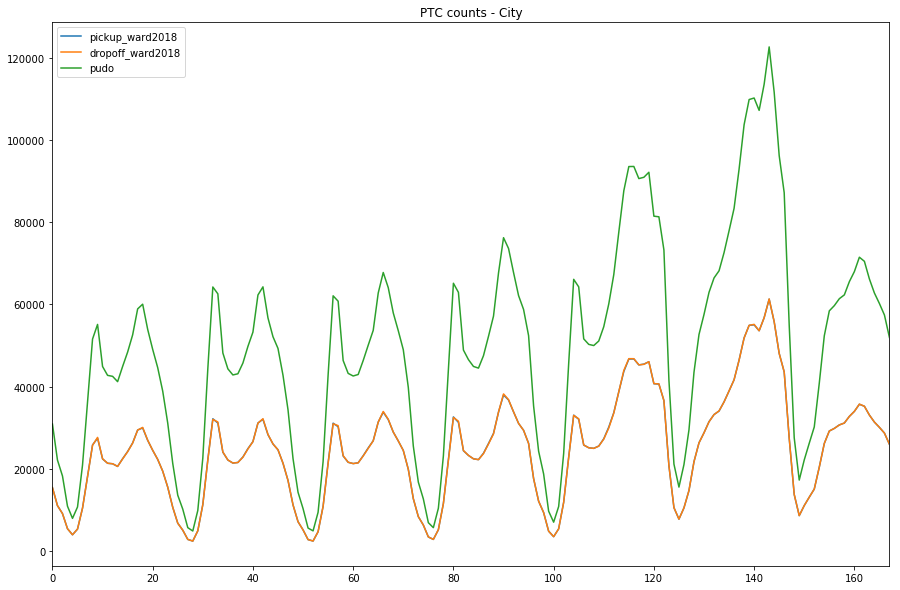

In [77]:
df_merge.plot(y=["pickup_ward2018", "dropoff_ward2018", "pudo"], kind="line", use_index=True,
             title='PTC counts - City',
             figsize=(15,10))

In [ ]:
df=

# Create json object and write to file
Format:  
```
{
	"keys": {
		"name": "tod",
		"values": [
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167
		]
	},
	"pudo": [0.3234158,0.21998841,0.18961688,0.15678278,0.13872403, 0.48019858,0.36938352...
        ]
}
```

In [78]:
ptcjson = {
    "keys":{
        "name":"tod", 
        "values":np.arange(df_merge.shape[0]).tolist()
    },
    "do":pd.to_numeric(df_merge['pudo'], downcast='signed').tolist()
}

ptcjson

{'keys': {'name': 'tod',
  'values': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   

## Write json to file
https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

In [ ]:
df_merge.shape

In [79]:
import json

mydir = '../src/data/'
# mydir = '/home/nangini/Documents/PROJECTS/BDITTO/VFH/DATA_STORY/DATA/JSONS/'

file = 'fig3_tod_city.json'

fname = mydir + file
with open(fname, 'w') as outfile:
    json.dump(ptcjson, outfile)

In [ ]:
print("200 OK")